![](grid.png)

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '../../') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
u.check_virtual_memory()

3.8.2 | packaged by conda-forge | (default, Feb 28 2020, 17:15:22) 
[GCC 7.3.0]
Virtual memory usage - total: 252 GB / available: 146 GB / percent used: 42.1 %


# Try to reproduce grid_noro

/modipsl/modeles/LMDZ/libf/phylmd/grid_noro_m.F90

Finally /modipsl/modeles/LMDZ/libf/dynphy_lonlat/phylmd/etat0dyn_netcdf.F90, either we compute the orographic parameters with grid_noro, either we read it:

In [ ]:
# SUBROUTINE conf_dat2d(title, xd, yd, xf, yf, champd, interbar)
# !
# !-------------------------------------------------------------------------------
# ! Author: P. Le Van
# !-------------------------------------------------------------------------------
# ! Purpose: Configure the 2D data field "champd" so that:
# !     - Longitudes are in [ -pi     pi   ]
# !     - Latitudes  are in [  pi/2. -pi/2 ]
# !  * xd / yd are initial lon / lats.
# !  * xf / yf are output  lon / lats, possibly modified to satisfy configuration.
# !  * interbar is TRUE for barycentric interpolation.

In [ ]:
# !--- READ SUB-CELL SCALES PARAMETERS FROM A FILE (AT RIGHT RESOLUTION)
#   OPEN(UNIT=66,FILE=oroparam,STATUS='OLD',IOSTAT=ierr)
#   IF(ierr==0.AND.read_orop) THEN
#     CLOSE(UNIT=66)
#     CALL read_noro(lon_in,lat_in,oroparam,                                     &
#                    phis,zmea0,zstd0,zsig0,zgam0,zthe0,zpic0,zval0,masque)
#   ELSE
# !--- CALL OROGRAPHY MODULE TO COMPUTE FIELDS
#     CALL grid_noro(lon_rad,lat_rad,relief_hi,lon_in,lat_in,                    &
#                    phis,zmea0,zstd0,zsig0,zgam0,zthe0,zpic0,zval0,masque)
#   END IF
#   phis = phis * 9.81
#   phis(iml,:) = phis(1,:)
#   DEALLOCATE(relief_hi,lon_rad,lat_rad)

In [ ]:
# !-------------------------------------------------------------------------------
# !
# SUBROUTINE grid_noro(xd,yd,zd,x,y,zphi,zmea,zstd,zsig,zgam,zthe,zpic,zval,mask)
# !
# !-------------------------------------------------------------------------------
# ! Author: F. Lott (see also Z.X. Li, A. Harzallah et L. Fairhead)
# !-------------------------------------------------------------------------------
# ! Purpose: Compute the Parameters of the SSO scheme as described in LOTT &MILLER
# !         (1997) and LOTT(1999).
# !-------------------------------------------------------------------------------
# ! Comments:
# !  * Target points are on a rectangular grid:
# !      iim+1 latitudes including North and South Poles;
# !      jjm+1 longitudes, with periodicity jjm+1=1.
# !  * At the poles, the fields value is repeated jjm+1 time.
# !  * The parameters a,b,c,d represent the limits of the target gridpoint region.
# !    The means over this region are calculated from USN data, ponderated by a
# !    weight proportional to the surface occupated by the data inside the model
# !    gridpoint area. In most circumstances, this weight is the ratio between the
# !    surfaces of the USN gridpoint area and the model gridpoint area. 
# !
# !           (c)
# !        ----d-----
# !        | . . . .|
# !        |        |
# !     (b)a . * . .b(a)
# !        |        |
# !        | . . . .|
# !        ----c-----
# !           (d)
# !  * Hard-coded US Navy dataset dimensions (imdp=2160 ; jmdp=1080) have been
# !    removed (ALLOCATABLE used).
# !  * iext (currently 10% of imdp) represents the margin to ensure output cells
# !    on the edge are contained in input cells.
# !===============================================================================



# !-------------------------------------------------------------------------------
# ! Arguments:
#   REAL, INTENT(IN)  :: xd(:), yd(:)  !--- INPUT  COORDINATES     (imdp) (jmdp)
#   REAL, INTENT(IN)  :: zd(:,:)       !--- INPUT  FIELD           (imdp,jmdp)
#   REAL, INTENT(IN)  :: x(:), y(:)    !--- OUTPUT COORDINATES     (imar+1) (jmar)
#   REAL, INTENT(OUT) :: zphi(:,:)     !--- GEOPOTENTIAL           (imar+1,jmar)
#   REAL, INTENT(OUT) :: zmea(:,:)     !--- MEAN OROGRAPHY         (imar+1,jmar)
#   REAL, INTENT(OUT) :: zstd(:,:)     !--- STANDARD DEVIATION     (imar+1,jmar)
#   REAL, INTENT(OUT) :: zsig(:,:)     !--- SLOPE                  (imar+1,jmar)
#   REAL, INTENT(OUT) :: zgam(:,:)     !--- ANISOTROPY             (imar+1,jmar)
#   REAL, INTENT(OUT) :: zthe(:,:)     !--- SMALL AXIS ORIENTATION (imar+1,jmar)
#   REAL, INTENT(OUT) :: zpic(:,:)     !--- MAXIMUM ALTITITUDE     (imar+1,jmar)
#   REAL, INTENT(OUT) :: zval(:,:)     !--- MINIMUM ALTITITUDE     (imar+1,jmar)
#   REAL, INTENT(OUT) :: mask(:,:)     !--- MASK                   (imar+1,jmar)
# !-------------------------------------------------------------------------------
# ! Local variables:
#   CHARACTER(LEN=256) :: modname="grid_noro"
#   REAL, ALLOCATABLE :: xusn(:), yusn(:)           ! dim (imdp+2*iext) (jmdp+2)
#   REAL, ALLOCATABLE :: zusn(:,:)                  ! dim (imdp+2*iext,jmdp+2)
# ! CORRELATIONS OF OROGRAPHY GRADIENT              ! dim (imar+1,jmar)
#   REAL, ALLOCATABLE :: ztz(:,:), zxtzx(:,:), zytzy(:,:), zxtzy(:,:), weight(:,:)
# ! CORRELATIONS OF USN OROGRAPHY GRADIENTS         ! dim (imar+2*iext,jmdp+2)
#   REAL, ALLOCATABLE :: zxtzxusn(:,:), zytzyusn(:,:), zxtzyusn(:,:)
#   REAL, ALLOCATABLE :: num_tot(:,:), num_lan(:,:) ! dim (imar+1,jmar)
#   REAL, ALLOCATABLE :: a(:), b(:)                 ! dim (imar+1)
#   REAL, ALLOCATABLE :: c(:), d(:)                 ! dim (jmar)
#   LOGICAL :: masque_lu
#   INTEGER :: i, ii, imdp, imar, iext
#   INTEGER :: j, jj, jmdp, jmar, nn
#   REAL    :: xpi, zdeltax, zlenx, weighx, xincr,  zweinor, xk, xl, xm
#   REAL    :: rad, zdeltay, zleny, weighy, masque, zweisud, xp, xq, xw

# On part du fichier Relief.nc

In [2]:
relief = xr.open_dataset('/home/mlalande/notebooks/Relief.nc').RELIEF
relief

<xarray.DataArray 'RELIEF' (latitude: 1080, longitude: 2160)>
[2332800 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -179.9167 -179.75 ... 179.75 179.9167
  * latitude   (latitude) float32 89.91655 89.74982 ... -89.74982 -89.91655
Attributes:
    units:     m
    title:     RELIEF
    lon_name:  RELIEF

In [3]:
# Grille cible
path = '/data/mlalande/ELC-144x142x79_clim'
limit = xr.open_dataset(path+'/Output/Boundary/ELC-144x142x79_clim_limit.nc')
grilles_gcm = xr.open_dataset(path+'/Output/Grid/ELC-144x142x79_grilles_gcm.nc')
start = xr.open_dataset(path+'/Output/Restart/ELC-144x142x79_clim_start.nc')
startphy = xr.open_dataset(path+'/Output/Restart/ELC-144x142x79_clim_startphy.nc')

orog_fx_IPSL = xr.open_dataarray('/bdd/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r1i1p1f1/fx/orog/gr/latest/orog_fx_IPSL-CM6A-LR_historical_r1i1p1f1_gr.nc')
cyclic = orog_fx_IPSL.isel(lon=slice(0,1)).copy()
cyclic.lon.values = [360.0, ]
orog_fx_IPSL_cyclic = xr.combine_nested([orog_fx_IPSL, cyclic], concat_dim='lon')

In [4]:
start

<xarray.Dataset>
Dimensions:   (index: 100, rlatu: 143, rlatv: 142, rlonu: 145, rlonv: 145, sig: 80, sigs: 79, temps: 1)
Coordinates:
  * rlonu     (rlonu) float64 -3.12 -3.076 -3.033 -2.989 ... 3.076 3.12 3.163
  * rlatu     (rlatu) float64 1.571 1.549 1.527 1.504 ... -1.527 -1.549 -1.571
  * rlonv     (rlonv) float64 -3.142 -3.098 -3.054 -3.011 ... 3.054 3.098 3.142
  * rlatv     (rlatv) float64 1.56 1.538 1.515 1.493 ... -1.515 -1.538 -1.56
  * temps     (temps) datetime64[ns] 1979-01-01
Dimensions without coordinates: index, sig, sigs
Data variables:
    controle  (index) float64 ...
    nivsigs   (sigs) float64 ...
    nivsig    (sig) float64 ...
    ap        (sig) float64 ...
    bp        (sig) float64 ...
    presnivs  (sigs) float64 ...
    cu        (rlatu, rlonu) float64 ...
    cv        (rlatv, rlonv) float64 ...
    aire      (rlatu, rlonv) float64 ...
    phisinit  (rlatu, rlonv) float64 ...
    ucov      (temps, sigs, rlatu, rlonu) float64 ...
    vcov      (temps, sigs, rlatv, rlonv) float64 ...
    teta      (temps, sigs, rlatu, rlonv) float64 ...
    H2Ov      (temps, sigs, rlatu, rlonv) float64 ...
    H2Ol      (temps, sigs, rlatu, rlonv) float64 ...
    H2Oi      (temps, sigs, rlatu, rlonv) float64 ...
    Aga       (temps, sigs, rlatu, rlonv) float64 ...
    masse     (temps, sigs, rlatu, rlonv) float64 ...
    ps        (temps, rlatu, rlonv) float64 ...
Attributes:
    title:    Fichier demarrage dynamique

In [5]:
orog_fx_IPSL_cyclic

<xarray.DataArray 'orog' (lat: 143, lon: 145)>
array([[2841.648 , 2841.648 , 2841.648 , ..., 2841.648 , 2841.648 ,
        2841.648 ],
       [2688.9688, 2697.9724, 2708.5688, ..., 2668.209 , 2677.9058,
        2688.9688],
       [2618.7102, 2638.589 , 2658.8015, ..., 2580.6404, 2599.4429,
        2618.7102],
       ...,
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
           0.    ],
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
           0.    ],
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
           0.    ]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -90.0 -88.73239 -87.46479 ... 87.46479 88.73239 90.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 352.5 355.0 357.5 360.0
Attributes:
    long_name:         Surface Altitude
    units:             m
    online_operation:  once
    cell_methods:      area: mean
    cell_measures:     area: areacella
    standard_name:     surface_altitude
    description:       The surface called 'surface' means the lower boundary ...

In [5]:
#   REAL, INTENT(IN)  :: xd(:), yd(:)  !--- INPUT  COORDINATES     (imdp) (jmdp)
#   REAL, INTENT(IN)  :: zd(:,:)       !--- INPUT  FIELD           (imdp,jmdp)
#   REAL, INTENT(IN)  :: x(:), y(:)    !--- OUTPUT COORDINATES     (imar+1) (jmar)

In [5]:
# Needs to be in radian
xd = np.deg2rad(relief.longitude)
yd = np.deg2rad(relief.latitude)
zd = relief.transpose()

# Radians? Yes I guess
# MODULE conf_dat_m does this actually before to call grid_noro in 
#   CALL conf_dat2d(orogvar, lon_ini, lat_ini, lon_rad, lat_rad, relief_hi,.FALSE.)
# Here I cheat because I already have this values in from the output start.nc
x = start.rlonv #np.deg2rad(orog_fx_IPSL_cyclic.lon-180)
y = start.rlatu #.sortby('lat', ascending=False)

imdp = xd.size
jmdp = yd.size

In [6]:
relief

<xarray.DataArray 'RELIEF' (latitude: 1080, longitude: 2160)>
[2332800 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -179.9167 -179.75 ... 179.75 179.9167
  * latitude   (latitude) float32 89.91655 89.74982 ... -89.74982 -89.91655
Attributes:
    units:     m
    title:     RELIEF
    lon_name:  RELIEF

In [7]:
iext = int(imdp/10) #  To extend for computation
xpi = np.pi # Pi
rad = 6371229 # Rayon de la Terre en mètres
# zdeltay = 2*xpi/jmdp*rad # Delta y en mètres (delta latitude) -> erreur facteur 2
zdeltay = xpi/jmdp*rad # Delta y en mètres (delta latitude)
zdeltay

18533.153908090968

# Erreur zdeltay ? Il y a un facteur 2

In [ ]:
def deg2km(nlon, nlat, lat):
    # Gives the size of a grid cell in km at the corresponding latitude
    R_earth = 6371
    x = 2*np.pi*R_earth/nlon*np.cos(np.deg2rad(lat))
    y = np.pi*R_earth/nlat # on ne multiplie pas par 2 car la latitude a slt 180°
    return {'x': x, 'y': y, 'units': 'km'}

## Check with my function

In [56]:
u.deg2km(nlon=relief.longitude.size, nlat=relief.latitude.size, lat=0)

{'x': 18.532487774093124, 'y': 18.532487774093124, 'units': 'km'}

# EXTENSION OF THE INPUT DATABASE TO PROCEED COMPUTATIONS AT BOUNDARIES:

In [ ]:
# !--- EXTENSION OF THE INPUT DATABASE TO PROCEED COMPUTATIONS AT BOUNDARIES:
#   ALLOCATE(xusn(imdp+2*iext))
#   xusn(1     +iext:imdp  +iext)=xd(:)
#   xusn(1          :       iext)=xd(1+imdp-iext:imdp)-2.*xpi
#   xusn(1+imdp+iext:imdp+2*iext)=xd(1          :iext)+2.*xpi

#   ALLOCATE(yusn(jmdp+2))
#   yusn(1       )=yd(1)   +(yd(1)   -yd(2))
#   yusn(2:jmdp+1)=yd(:)
#   yusn(  jmdp+2)=yd(jmdp)+(yd(jmdp)-yd(jmdp-1))

#   ALLOCATE(zusn(imdp+2*iext,jmdp+2))
#   zusn(1       +iext:imdp  +iext,2:jmdp+1)=zd  (:                   ,     :)
#   zusn(1            :       iext,2:jmdp+1)=zd  (imdp-iext+1:imdp    ,     :)
#   zusn(1+imdp  +iext:imdp+2*iext,2:jmdp+1)=zd  (1:iext              ,     :)
#   zusn(1            :imdp/2+iext,       1)=zusn(1+imdp/2:imdp  +iext,     2)
#   zusn(1+imdp/2+iext:imdp+2*iext,       1)=zusn(1       :imdp/2+iext,     2)
#   zusn(1            :imdp/2+iext,  jmdp+2)=zusn(1+imdp/2:imdp  +iext,jmdp+1)
#   zusn(1+imdp/2+iext:imdp+2*iext,  jmdp+2)=zusn(1       :imdp/2+iext,jmdp+1)

In [12]:
xd

<xarray.DataArray 'longitude' (longitude: 2160)>
array([-3.1401389, -3.1372292, -3.1343198, ...,  3.1343198,  3.1372292,
        3.1401389], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -179.9167 -179.75 ... 179.75 179.9167

In [8]:
xusn = np.zeros(imdp+2*iext)
                
xusn[iext:imdp+iext] = xd.values
xusn[:iext] = xd[imdp-iext:imdp]-2.*xpi
xusn[imdp+iext:imdp+2*iext] = xd[:iext]+2.*xpi
xusn

array([-3.76845574, -3.76554608, -3.76263499, ...,  3.76263499,
        3.76554608,  3.76845574])

In [14]:
yd

<xarray.DataArray 'latitude' (latitude: 1080)>
array([ 1.5693399,  1.5664299,  1.5635198, ..., -1.5635198, -1.5664299,
       -1.5693399], dtype=float32)
Coordinates:
  * latitude  (latitude) float32 89.91655 89.74982 ... -89.74982 -89.91655

In [9]:
yusn = np.zeros(jmdp+2)
yusn[0] = yd[0].values + yd[0].values - yd[1].values
yusn[1:jmdp+1] = yd.values
yusn[-1] = yd[-1]+(yd[-1]-yd[-2])
yusn

array([ 1.57224989,  1.56933987,  1.56642985, ..., -1.56642985,
       -1.56933987, -1.57224989])

In [10]:
# np.pad can simply things... and in the future xr.pad even better
zusn = np.ones((imdp+2*iext,jmdp+2))

zusn[iext:imdp+iext,1:jmdp+1] = zd.values

zusn[:iext,1:jmdp+1] = zd[imdp-iext:imdp,:]
zusn[imdp+iext:imdp+2*iext,1:jmdp+1] = zd[:iext,:]

zusn[:,0] = zusn[:,1]
zusn[:,-1] = zusn[:,-2]

zusn.shape

(2592, 1082)

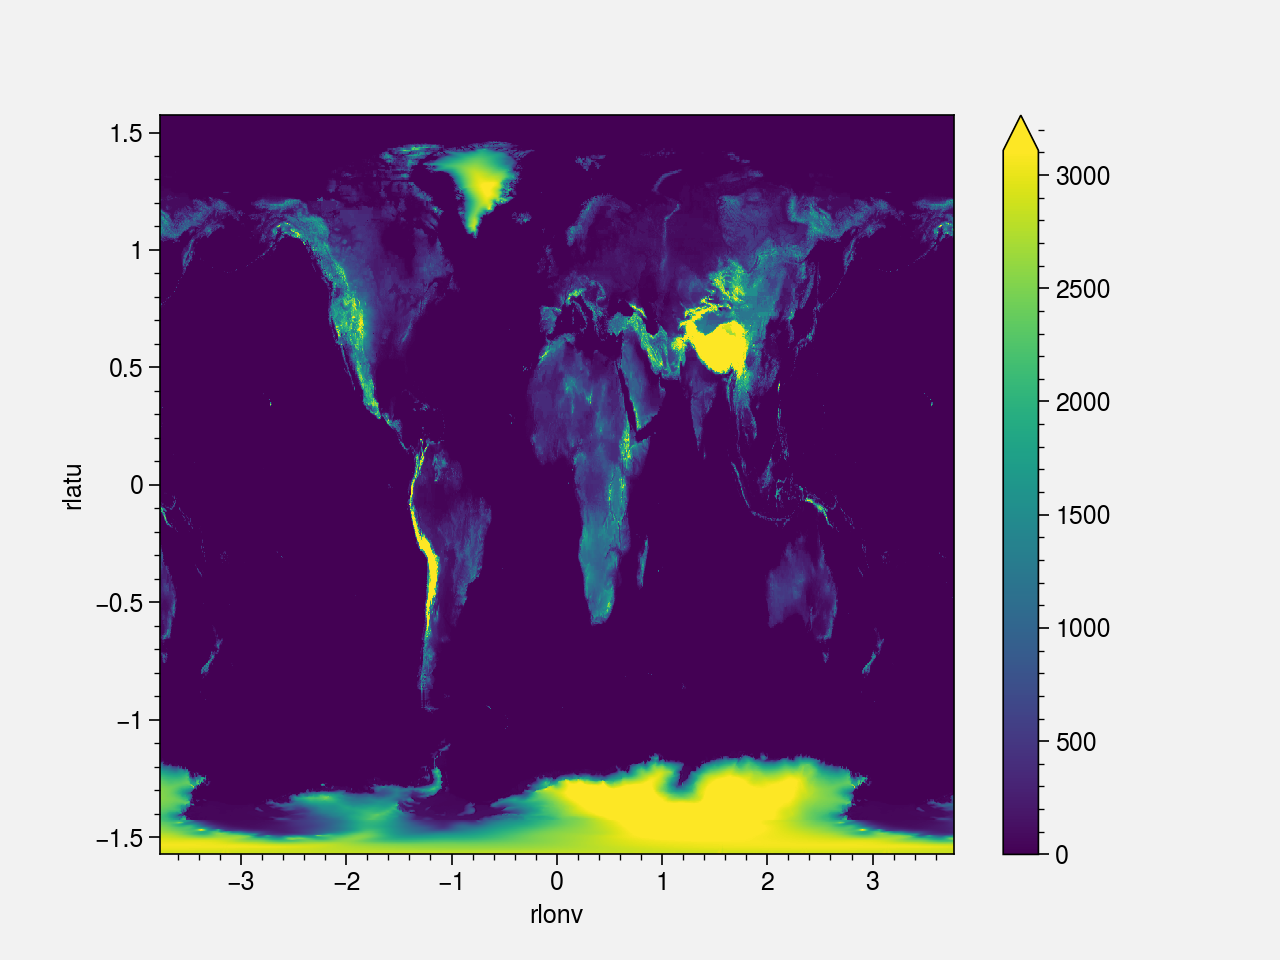

In [17]:
xr.DataArray(zusn.transpose(), coords=[yusn, xusn], dims=['rlatu', 'rlonv']).plot(robust=True)

# COMPUTE LIMITS OF MODEL GRIDPOINT AREA (REGULAR GRID)

In [ ]:
# !--- COMPUTE LIMITS OF MODEL GRIDPOINT AREA (REGULAR GRID)
#   ALLOCATE(a(imar+1),b(imar+1))
#   b(1:imar)=(x(1:imar  )+ x(2:imar+1))/2.0
#   b(imar+1)= x(  imar+1)+(x(  imar+1)-x(imar))/2.0
#   a(1)=x(1)-(x(2)-x(1))/2.0
#   a(2:imar+1)= b(1:imar)

#   ALLOCATE(c(jmar),d(jmar))
#   d(1:jmar-1)=(y(1:jmar-1)+ y(2:jmar))/2.0
#   d(  jmar  )= y(  jmar  )+(y(  jmar)-y(jmar-1))/2.0
#   c(1)=y(1)-(y(2)-y(1))/2.0
#   c(2:jmar)=d(1:jmar-1)


# !           (c)
# !        ----d-----
# !        | . . . .|
# !        |        |
# !     (b)a . * . .b(a)
# !        |        |
# !        | . . . .|
# !        ----c-----
# !           (d)

In [11]:
imar = orog_fx_IPSL.lon.size
imar

144

In [12]:
jmar = orog_fx_IPSL.lat.size
jmar

143

In [13]:
#   ALLOCATE(a(imar+1),b(imar+1))
a = np.zeros(imar+1)
b = np.zeros(imar+1)

#   b(1:imar)=(x(1:imar  )+ x(2:imar+1))/2.0
b[:imar] = (x[:-1].values + x[1:].values)/2
#   b(imar+1)= x(  imar+1)+(x(  imar+1)-x(imar))/2.0
b[imar] = x[-1].values + (x[-1].values-x[-2].values)/2.0

#   a(1)=x(1)-(x(2)-x(1))/2.0
a[0] = x[0].values - (x[1].values-x[0].values)/2.0
#   a(2:imar+1)= b(1:imar)
a[1:imar+1] = b[:imar]

In [14]:
d = np.zeros(jmar)
c = np.zeros(jmar)

# d et c opposite ?
#   d(1:jmar-1)=(y(1:jmar-1)+ y(2:jmar))/2.0
d[:jmar-1] = (y[:-1].values + y[1:].values)/2
#   d(  jmar  )= y(  jmar  )+(y(  jmar)-y(jmar-1))/2.0
d[jmar-1] = y[-1].values + (y[-1].values-y[-2].values)/2.0
#   c(1)=y(1)-(y(2)-y(1))/2.0
c[0] = y[0].values - (y[1].values-y[0].values)/2.0
#   c(2:jmar)=d(1:jmar-1)
c[1:jmar] = d[:jmar-1]

# INITIALIZATIONS:

In [ ]:
#   REAL, INTENT(OUT) :: zphi(:,:)     !--- GEOPOTENTIAL           (imar+1,jmar)
#   REAL, INTENT(OUT) :: zmea(:,:)     !--- MEAN OROGRAPHY         (imar+1,jmar)
#   REAL, INTENT(OUT) :: zstd(:,:)     !--- STANDARD DEVIATION     (imar+1,jmar)
#   REAL, INTENT(OUT) :: zsig(:,:)     !--- SLOPE                  (imar+1,jmar)
#   REAL, INTENT(OUT) :: zgam(:,:)     !--- ANISOTROPY             (imar+1,jmar)
#   REAL, INTENT(OUT) :: zthe(:,:)     !--- SMALL AXIS ORIENTATION (imar+1,jmar)
#   REAL, INTENT(OUT) :: zpic(:,:)     !--- MAXIMUM ALTITITUDE     (imar+1,jmar)
#   REAL, INTENT(OUT) :: zval(:,:)     !--- MINIMUM ALTITITUDE     (imar+1,jmar)
#   REAL, INTENT(OUT) :: mask(:,:)     !--- MASK                   (imar+1,jmar)

In [15]:
zphi = np.zeros((imar+1,jmar))     # GEOPOTENTIAL           (imar+1,jmar)
zmea = np.zeros((imar+1,jmar))     # MEAN OROGRAPHY         (imar+1,jmar)
zstd = np.zeros((imar+1,jmar))     # STANDARD DEVIATION     (imar+1,jmar)
zsig = np.zeros((imar+1,jmar))     # SLOPE                  (imar+1,jmar)
zgam = np.zeros((imar+1,jmar))     # ANISOTROPY             (imar+1,jmar)
zthe = np.zeros((imar+1,jmar))     # SMALL AXIS ORIENTATION (imar+1,jmar)
zpic = np.zeros((imar+1,jmar))     # MAXIMUM ALTITITUDE     (imar+1,jmar)
zval = np.zeros((imar+1,jmar))     # MINIMUM ALTITITUDE     (imar+1,jmar)
mask = np.zeros((imar+1,jmar))     # MASK                   (imar+1,jmar)

In [ ]:
# !--- INITIALIZATIONS:
#   ALLOCATE(weight(imar+1,jmar)); weight(:,:)= 0.0
#   ALLOCATE(zxtzx (imar+1,jmar)); zxtzx (:,:)= 0.0
#   ALLOCATE(zytzy (imar+1,jmar)); zytzy (:,:)= 0.0
#   ALLOCATE(zxtzy (imar+1,jmar)); zxtzy (:,:)= 0.0
#   ALLOCATE(ztz   (imar+1,jmar)); ztz   (:,:)= 0.0
#   zmea(:,:)= 0.0
#   zpic(:,:)=-1.E+10
#   zval(:,:)= 1.E+10

In [16]:
weight = np.zeros((imar+1,jmar))
zxtzx  = np.zeros((imar+1,jmar))
zytzy  = np.zeros((imar+1,jmar))
zxtzy  = np.zeros((imar+1,jmar))
ztz    = np.zeros((imar+1,jmar))
zmea[:,:]   = 0.0
zpic[:,:]   =-1.E+10
zval[:,:]   = 1.E+10

# COMPUTE SLOPES CORRELATIONS ON USN GRID

In [105]:
# !--- COMPUTE SLOPES CORRELATIONS ON USN GRID
# ! CORRELATIONS OF USN OROGRAPHY GRADIENTS  ! dim (imdp+2*iext,jmdp+2)
#   ALLOCATE(zytzyusn(imdp+2*iext,jmdp+2)); zytzyusn(:,:)=0.0
#   ALLOCATE(zxtzxusn(imdp+2*iext,jmdp+2)); zxtzxusn(:,:)=0.0
#   ALLOCATE(zxtzyusn(imdp+2*iext,jmdp+2)); zxtzyusn(:,:)=0.0
#   DO j = 2, jmdp+1
#     zdeltax=zdeltay*cos(yusn(j))
#     DO i = 2, imdp+2*iext-1
#       zytzyusn(i,j)=(zusn(i,j+1)-zusn(i,j-1))**2/zdeltay**2
#       zxtzxusn(i,j)=(zusn(i+1,j)-zusn(i-1,j))**2/zdeltax**2
#       zxtzyusn(i,j)=(zusn(i,j+1)-zusn(i,j-1))   /zdeltay  &
#      &             *(zusn(i+1,j)-zusn(i-1,j))   /zdeltax
#     END DO
#   END DO

array([[1.e+10, 1.e+10, 1.e+10, ..., 1.e+10, 1.e+10, 1.e+10],
       [1.e+10, 1.e+10, 1.e+10, ..., 1.e+10, 1.e+10, 1.e+10],
       [1.e+10, 1.e+10, 1.e+10, ..., 1.e+10, 1.e+10, 1.e+10],
       ...,
       [1.e+10, 1.e+10, 1.e+10, ..., 1.e+10, 1.e+10, 1.e+10],
       [1.e+10, 1.e+10, 1.e+10, ..., 1.e+10, 1.e+10, 1.e+10],
       [1.e+10, 1.e+10, 1.e+10, ..., 1.e+10, 1.e+10, 1.e+10]])

# /!\ problème de zdeltay... 2 fois trop grand

In [17]:
zytzyusn = np.zeros((imdp+2*iext,jmdp+2))
zxtzxusn = np.zeros((imdp+2*iext,jmdp+2))
zxtzyusn = np.zeros((imdp+2*iext,jmdp+2))
  
for j in range(1,jmdp+1): # poles duplicated not included
#     zdeltax = zdeltay*cos(yusn(j)) # not good ? only square grids
    zdeltax = 2*np.pi*rad/imdp*np.cos(yusn[j])
    for i in range(1,imdp+2*iext-1): # don't take the last points ? (but include iext) -> ok for computation
        zytzyusn[i,j] = (zusn[i,j+1]-zusn[i,j-1])**2/zdeltay**2
        zxtzxusn[i,j] = (zusn[i+1,j]-zusn[i-1,j])**2/zdeltax**2
        zxtzyusn[i,j] = (zusn[i,j+1]-zusn[i,j-1])/zdeltay*(zusn[i+1,j]-zusn[i-1,j])/zdeltax

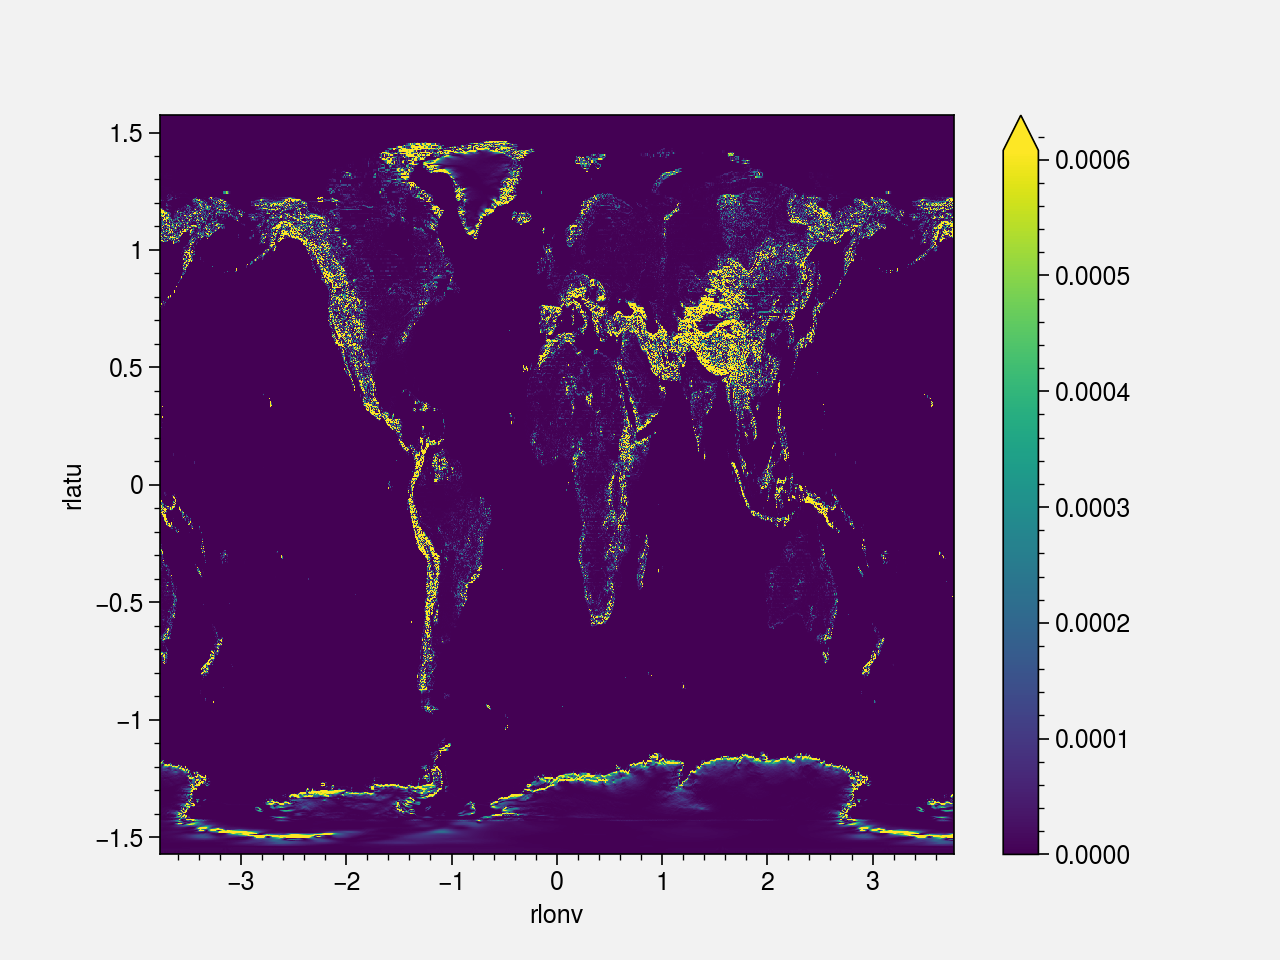

In [50]:
xr.DataArray(zytzyusn.transpose(), coords=[yusn, xusn], dims=['rlatu', 'rlonv']).plot(robust=True)

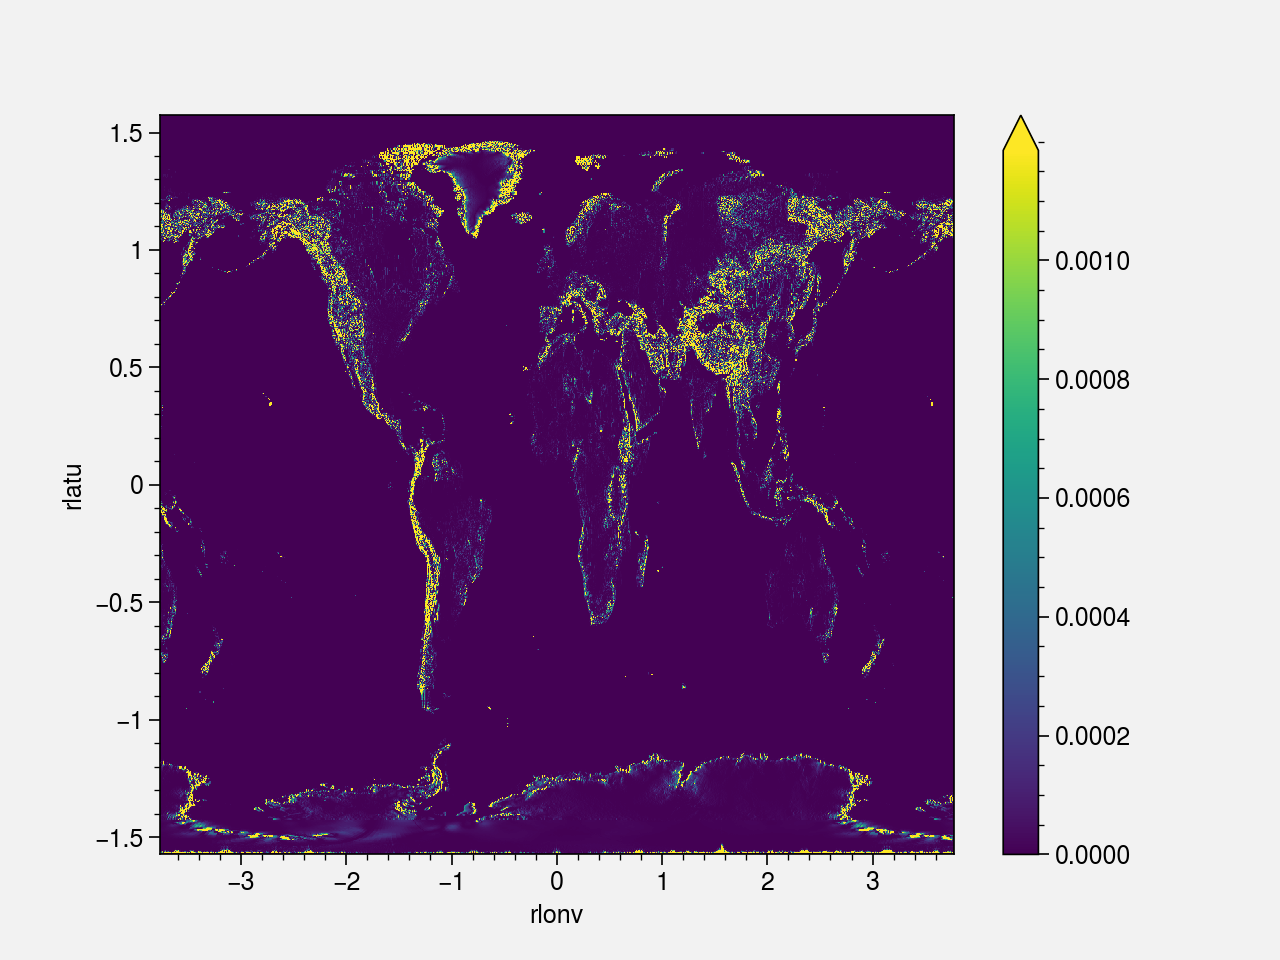

In [42]:
xr.DataArray(zxtzxusn.transpose(), coords=[yusn, xusn], dims=['rlatu', 'rlonv']).plot(robust=True)

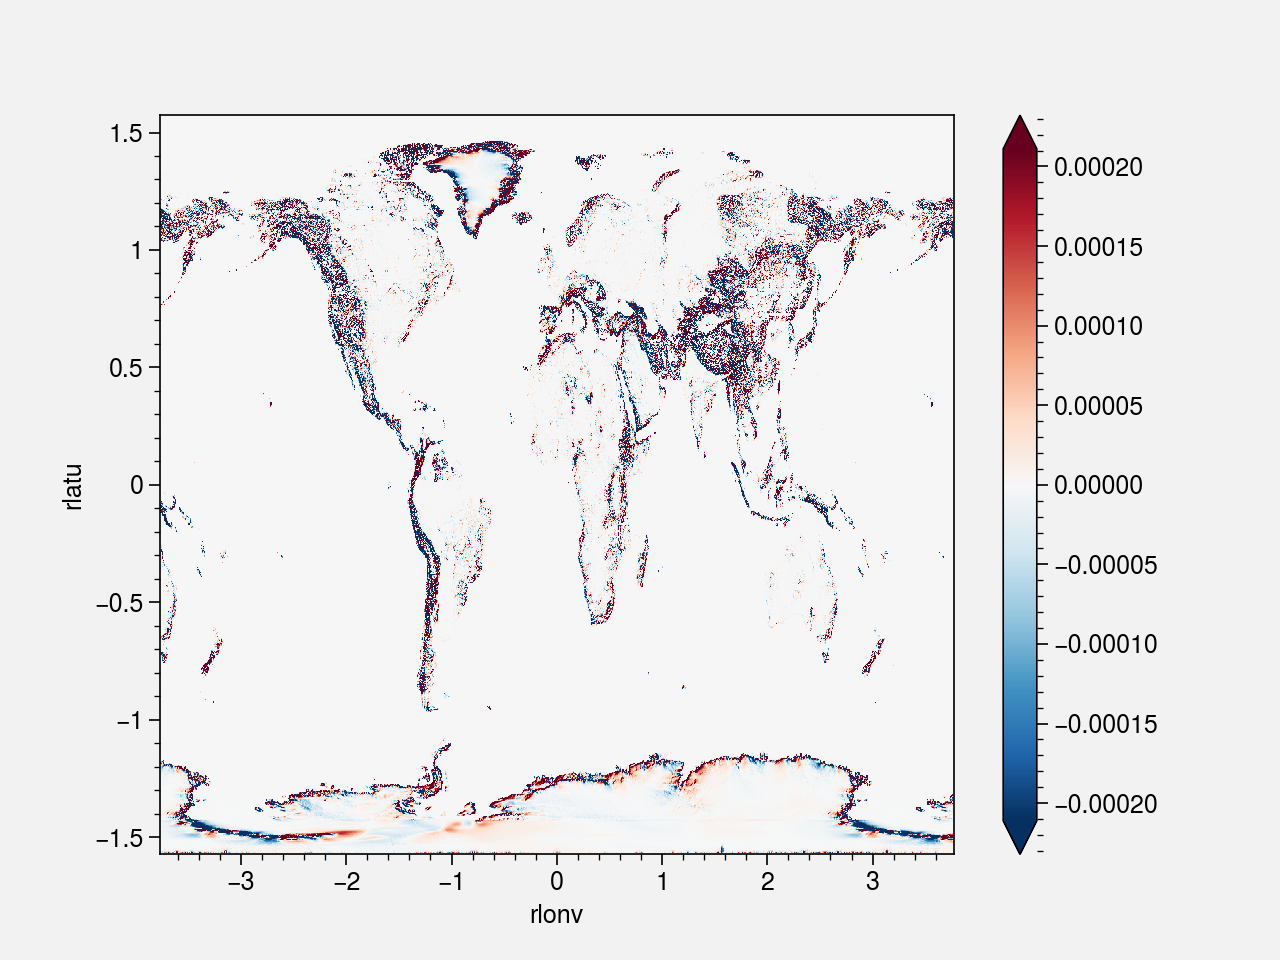

In [43]:
xr.DataArray(zxtzyusn.transpose(), coords=[yusn, xusn], dims=['rlatu', 'rlonv']).plot(robust=True)

# SUMMATION OVER GRIDPOINT AREA

In [ ]:
# !--- SUMMATION OVER GRIDPOINT AREA
#   zleny=xpi/REAL(jmdp)*rad
#   xincr=xpi/REAL(jmdp)/2.
#   ALLOCATE(num_tot(imar+1,jmar)); num_tot(:,:)=0.
#   ALLOCATE(num_lan(imar+1,jmar)); num_lan(:,:)=0.
#   DO ii = 1, imar+1
#     DO jj = 1, jmar
#       DO j = 2,jmdp+1 
#         zlenx=zleny*COS(yusn(j))
#         zdeltax=zdeltay*COS(yusn(j))
#         weighy=(xincr+AMIN1(c(jj)-yusn(j),yusn(j)-d(jj)))*rad
#         weighy=AMAX1(0.,AMIN1(weighy,zleny))

#         IF(weighy==0.) CYCLE
#         DO i = 2, imdp+2*iext-1
#           weighx=(xincr+AMIN1(xusn(i)-a(ii),b(ii)-xusn(i)))*rad*COS(yusn(j))
#           weighx=AMAX1(0.,AMIN1(weighx,zlenx))

#           IF(weighx==0.) CYCLE
#           num_tot(ii,jj)=num_tot(ii,jj)+1.0
#           IF(zusn(i,j)>=1.)num_lan(ii,jj)=num_lan(ii,jj)+1.0
#           weight(ii,jj)=weight(ii,jj)+weighx*weighy
#           zxtzx(ii,jj)=zxtzx(ii,jj)+zxtzxusn(i,j)*weighx*weighy
#           zytzy(ii,jj)=zytzy(ii,jj)+zytzyusn(i,j)*weighx*weighy
#           zxtzy(ii,jj)=zxtzy(ii,jj)+zxtzyusn(i,j)*weighx*weighy
#           ztz  (ii,jj)=  ztz(ii,jj)+zusn(i,j)*zusn(i,j)*weighx*weighy
#           zmea (ii,jj)= zmea(ii,jj)+zusn(i,j)*weighx*weighy !--- MEAN
#           zpic (ii,jj)=AMAX1(zpic(ii,jj),zusn(i,j))         !--- PEAKS
#           zval (ii,jj)=AMIN1(zval(ii,jj),zusn(i,j))         !--- VALLEYS
#         END DO
#       END DO
#     END DO
#   END DO

### Cette fois ok il n'y a pas le facteur 2

In [18]:
#   zleny=xpi/REAL(jmdp)*rad
zleny = xpi/jmdp*rad
zleny

18533.153908090968

In [19]:
# taille en radian d'une demi cellule (de la grille haute résolution) ?
#   xincr=xpi/REAL(jmdp)/2.
xincr = xpi/jmdp/2
xincr

0.001454441043328608

In [20]:
(yd[0] - yd[1])/2

<xarray.DataArray 'latitude' ()>
array(0.00145501)

In [21]:
#   ALLOCATE(num_tot(imar+1,jmar)); num_tot(:,:)=0.
#   ALLOCATE(num_lan(imar+1,jmar)); num_lan(:,:)=0.
num_tot = np.zeros((imar+1,jmar)) 
num_lan = np.zeros((imar+1,jmar))
num_lan.shape

(145, 143)

In [106]:
ii=0
jj=0
j=1

np.min([c[jj]-yusn[j], yusn[j]-d[jj]])

0.009605490575002928

In [ ]:
# c / d inversées ?
# !           (c)
# !        ----d-----
# !        | . . . .|
# !        |        |
# !     (b)a . * . .b(a)
# !        |        |
# !        | . . . .|
# !        ----c-----
# !           (d)

In [30]:
ii=0
jj=0
j=1
i=1

(xincr+np.min([xusn[i]-a[ii], b[ii]-xusn[i]]))*rad*np.cos(yusn[j])

-5573.976534742512

In [31]:
xusn[i]-a[ii]

-0.6021368142105952

In [32]:
b[ii]-xusn[i]

0.6457700455104534

In [23]:
xincr

0.001454441043328608

In [33]:
-170--180

10

In [38]:
-177.5--180

2.5

In [42]:
yd

<xarray.DataArray 'latitude' (latitude: 1080)>
array([ 1.5693399,  1.5664299,  1.5635198, ..., -1.5635198, -1.5664299,
       -1.5693399], dtype=float32)
Coordinates:
  * latitude  (latitude) float32 89.91655 89.74982 ... -89.74982 -89.91655

In [41]:
c

array([ 1.58185827,  1.55973438,  1.53761049,  1.5154866 ,  1.49336271,
        1.47123881,  1.44911492,  1.42699103,  1.40486714,  1.38274325,
        1.36061935,  1.33849546,  1.31637157,  1.29424768,  1.27212379,
        1.24999989,  1.227876  ,  1.20575211,  1.18362822,  1.16150433,
        1.13938043,  1.11725654,  1.09513265,  1.07300876,  1.05088487,
        1.02876097,  1.00663708,  0.98451319,  0.9623893 ,  0.94026541,
        0.91814151,  0.89601762,  0.87389373,  0.85176984,  0.82964595,
        0.80752206,  0.78539816,  0.76327427,  0.74115038,  0.71902649,
        0.6969026 ,  0.6747787 ,  0.65265481,  0.63053092,  0.60840703,
        0.58628314,  0.56415924,  0.54203535,  0.51991146,  0.49778757,
        0.47566368,  0.45353978,  0.43141589,  0.409292  ,  0.38716811,
        0.36504422,  0.34292032,  0.32079643,  0.29867254,  0.27654865,
        0.25442476,  0.23230087,  0.21017697,  0.18805308,  0.16592919,
        0.1438053 ,  0.12168141,  0.09955751,  0.07743362,  0.05

In [44]:
100-80

20

In [50]:
90-88.7

1.2999999999999972

In [49]:
88.7-88.7

0.0

In [ ]:
(xincr+np.min([c[jj]-yusn[j], yusn[j]-d[jj]]))*rad


In [55]:
jmar

143

In [56]:
for ii in range(0,imar+1):
    print(str(ii)+'/144')
    for jj in range(0,jmar):
        print(str(jj)+'/143')
        for j in range(1,jmdp+1):
            
# for ii in range(0,1):
#     for jj in range(0,1):
#         for j in range(1,2):
            zlenx = zleny*np.cos(yusn[j]) # à changer -> pas carré !
#             zdeltax = zdeltay*np.cos(yusn[j]) # Attention du coup censé être le double mais utilisé
            #         weighy=(xincr+AMIN1(c(jj)-yusn(j),yusn(j)-d(jj)))*rad
            weighy = (xincr+np.min([c[jj]-yusn[j], yusn[j]-d[jj]]))*rad
            #         weighy=AMAX1(0.,AMIN1(weighy,zleny))     
            weighy = np.max([0., np.min([weighy,zleny])])  
            
            # IF(weighy==0.) CYCLE
            if (weighy != 0):
                for i in range(1,imdp+2*iext-1):
#                 for i in range(1,2):
#           weighx=(xincr+AMIN1(xusn(i)-a(ii),b(ii)-xusn(i)))*rad*COS(yusn(j))
                    # Négatif si la maille HR est hors de la maille LR +- l'incrément (permet d'ajouter les poids pour les limites)
                    weighx = (xincr+np.min([xusn[i]-a[ii], b[ii]-xusn[i]]))*rad*np.cos(yusn[j])
#           weighx=AMAX1(0.,AMIN1(weighx,zlenx))
                    # Du coup si weighx est négatif -> 0 et ne peut pas être plus grand que la longueur de la maille
                    weighx = np.max([0., np.min([weighx,zlenx])])
                    
                    if (weighx != 0):
                        num_tot[ii,jj] = num_tot[ii,jj] + 1.0
                        if (zusn[i,j] >= 1.): num_lan[ii,jj] = num_lan[ii,jj] + 1.0
                        weight[ii,jj] = weight[ii,jj] + weighx*weighy
#                         zxtzx[ii,jj] = zxtzx[ii,jj] + zxtzxusn[i,j]*weighx*weighy
#                         zytzy[ii,jj] = zytzy[ii,jj] + zytzyusn[i,j]*weighx*weighy
#                         zxtzy[ii,jj] = zxtzy[ii,jj] + zxtzyusn[i,j]*weighx*weighy
#                         ztz[ii,jj] =   ztz[ii,jj] + zusn[i,j]*zusn[i,j]*weighx*weighy
                        zmea[ii,jj] =  zmea[ii,jj] + zusn[i,j]*weighx*weighy # MEAN
                        zpic[ii,jj] = np.max([zpic[ii,jj], zusn[i,j]])         # PEAKS
                        zval[ii,jj] = np.max([zval[ii,jj], zusn[i,j]])         # VALLEYS
#                         print(zmea[ii,jj])
                        

0/144
0/143
1/143
2/143
3/143
4/143
5/143
6/143
7/143
8/143
9/143
10/143
11/143
12/143
13/143
14/143
15/143
16/143
17/143
18/143
19/143
20/143
21/143
22/143
23/143
24/143
25/143
26/143
27/143
28/143
29/143
30/143
31/143
32/143
33/143
34/143
35/143
36/143
37/143
38/143
39/143
40/143
41/143
42/143
43/143
44/143
45/143
46/143
47/143
48/143
49/143
50/143
51/143
52/143
53/143
54/143
55/143
56/143
57/143
58/143
59/143
60/143
61/143
62/143
63/143
64/143
65/143
66/143
67/143
68/143
69/143
70/143
71/143
72/143
73/143
74/143
75/143
76/143
77/143
78/143
79/143
80/143
81/143
82/143
83/143
84/143
85/143
86/143
87/143
88/143
89/143
90/143
91/143
92/143
93/143
94/143
95/143
96/143
97/143
98/143
99/143
100/143
101/143
102/143
103/143
104/143
105/143
106/143
107/143
108/143
109/143
110/143
111/143
112/143
113/143
114/143
115/143
116/143
117/143
118/143
119/143
120/143
121/143
122/143
123/143
124/143
125/143
126/143
127/143
128/143
129/143
130/143
131/143
132/143
133/143
134/143
135/143
136/143
137/143


128/143
129/143
130/143
131/143
132/143
133/143
134/143
135/143
136/143
137/143
138/143
139/143
140/143
141/143
142/143
8/144
0/143
1/143
2/143
3/143
4/143
5/143
6/143
7/143
8/143
9/143
10/143
11/143
12/143
13/143
14/143
15/143
16/143
17/143
18/143
19/143
20/143
21/143
22/143
23/143
24/143
25/143
26/143
27/143
28/143
29/143
30/143
31/143
32/143
33/143
34/143
35/143
36/143
37/143
38/143
39/143
40/143
41/143
42/143
43/143
44/143
45/143
46/143
47/143
48/143
49/143
50/143
51/143
52/143
53/143
54/143
55/143
56/143
57/143
58/143
59/143
60/143
61/143
62/143
63/143
64/143
65/143
66/143
67/143
68/143
69/143
70/143
71/143
72/143
73/143
74/143
75/143
76/143
77/143
78/143
79/143
80/143
81/143
82/143
83/143
84/143
85/143
86/143
87/143
88/143
89/143
90/143
91/143
92/143
93/143
94/143
95/143
96/143
97/143
98/143
99/143
100/143
101/143
102/143
103/143
104/143
105/143
106/143
107/143
108/143
109/143
110/143
111/143
112/143
113/143
114/143
115/143
116/143
117/143
118/143
119/143
120/143
121/143
122/143


KeyboardInterrupt: 

In [148]:
zmea

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [144]:
zusn

array([[   0.        ,    0.        ,    0.        , ..., 2889.87988281,
        2882.18994141, 2882.18994141],
       [   0.        ,    0.        ,    0.        , ..., 2886.62011719,
        2878.17993164, 2878.17993164],
       [   0.        ,    0.        ,    0.        , ..., 2881.52001953,
        2874.51000977, 2874.51000977],
       ...,
       [   0.        ,    0.        ,    0.        , ..., 2843.87011719,
        2848.16992188, 2848.16992188],
       [   0.        ,    0.        ,    0.        , ..., 2846.0300293 ,
        2849.62988281, 2849.62988281],
       [   0.        ,    0.        ,    0.        , ..., 2847.18994141,
        2851.13989258, 2851.13989258]])

In [142]:
num_tot.shape

(145, 143)

In [56]:
#   DO ii = 1, imar+1
#     DO jj = 1, jmar
#       DO j = 2,jmdp+1 
#         zlenx=zleny*COS(yusn(j))
#         zdeltax=zdeltay*COS(yusn(j))
#         weighy=(xincr+AMINa1(c(jj)-yusn(j),yusn(j)-d(jj)))*rad
#         weighy=AMAX1(0.,AMIN1(weighy,zleny))

#         IF(weighy==0.) CYCLE
#         DO i = 2, imdp+2*iext-1
#           weighx=(xincr+AMIN1(xusn(i)-a(ii),b(ii)-xusn(i)))*rad*COS(yusn(j))
#           weighx=AMAX1(0.,AMIN1(weighx,zlenx))

#           IF(weighx==0.) CYCLE
#           num_tot(ii,jj)=num_tot(ii,jj)+1.0
#           IF(zusn(i,j)>=1.)num_lan(ii,jj)=num_lan(ii,jj)+1.0
#           weight(ii,jj)=weight(ii,jj)+weighx*weighy
#           zxtzx(ii,jj)=zxtzx(ii,jj)+zxtzxusn(i,j)*weighx*weighy
#           zytzy(ii,jj)=zytzy(ii,jj)+zytzyusn(i,j)*weighx*weighy
#           zxtzy(ii,jj)=zxtzy(ii,jj)+zxtzyusn(i,j)*weighx*weighy
#           ztz  (ii,jj)=  ztz(ii,jj)+zusn(i,j)*zusn(i,j)*weighx*weighy
#           zmea (ii,jj)= zmea(ii,jj)+zusn(i,j)*weighx*weighy !--- MEAN
#           zpic (ii,jj)=AMAX1(zpic(ii,jj),zusn(i,j))         !--- PEAKS
#           zval (ii,jj)=AMIN1(zval(ii,jj),zusn(i,j))         !--- VALLEYS
#         END DO
#       END DO
#     END DO
#   END DO